# Importing Libraries 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, concatenate, BatchNormalization, MultiHeadAttention, LayerNormalization, LeakyReLU, Flatten,
                                      Embedding, Lambda, Add,  Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional, LSTM)
from tensorflow.keras.optimizers import Adam
import json
import os

# Data Loading and Exploration

In [2]:
excel_path = r'c:/Users/LENOVO/OneDrive/Desktop/capstone project/13059_2018_1459_MOESM5_ESM.xlsx'
xls = pd.ExcelFile(excel_path)
sheets = xls.sheet_names
dfs = {sheet: xls.parse(sheet) for sheet in sheets}

hct116_df=dfs['hct116']
hek293t_df=dfs['hek293t']
hela_df=dfs['hela']
hl60_df=dfs['hl60']

In [3]:
print(f'HCT116 shape: {hct116_df.shape}')
print(f'HEK293T shape: {hek293t_df.shape}')
print(f'HELA shape: {hela_df.shape}')
print(f'HL60 shape: {hl60_df.shape}')

HCT116 shape: (4239, 6)
HEK293T shape: (2333, 6)
HELA shape: (8101, 6)
HL60 shape: (2076, 6)


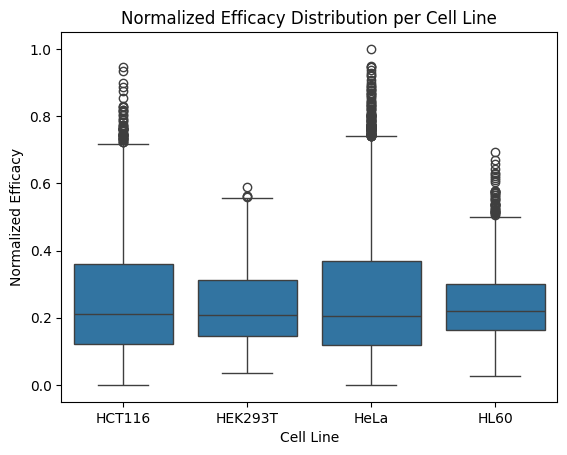

In [4]:
combined_df = pd.concat([
    hct116_df.assign(CellLine='HCT116'),
    hek293t_df.assign(CellLine='HEK293T'),
    hela_df.assign(CellLine='HeLa'),
    hl60_df.assign(CellLine='HL60')
])

sns.boxplot(data=combined_df, x='CellLine', y='Normalized efficacy')
plt.title('Normalized Efficacy Distribution per Cell Line')
plt.ylabel('Normalized Efficacy')
plt.xlabel('Cell Line')
plt.show()

In [5]:
'''
hct116_df.to_csv('hct116.csv', index=False)
hek293t_df.to_csv('hek293t.csv', index=False)
hela_df.to_csv('hela_df.csv', index=False)
hl60_df.to_csv('hl60_df.csv', index=False)
'''

"\nhct116_df.to_csv('hct116.csv', index=False)\nhek293t_df.to_csv('hek293t.csv', index=False)\nhela_df.to_csv('hela_df.csv', index=False)\nhl60_df.to_csv('hl60_df.csv', index=False)\n"

In [6]:
df=hela_df.copy()

In [7]:
df

,Chromosome,Start,End,Strand,sgRNA,Normalized efficacy
0,chr4,184605984,184606006,-,ACATCAGGTTACCTCTACCAAGG,0.177011
1,chr1,11736866,11736888,+,CTGATGCCAGCTAGTGGGCGAGG,0.001588
2,chr4,25379067,25379089,+,CTGTTTCCCATCCTTCCGGGTGG,0.498712
3,chr12,57936737,57936759,-,AATGTATGCACAGGGAACAGAGG,0.114708
4,chr2,131103494,131103516,-,CCAGACTCACCCGCTTGCCCAGG,0.250399
...,...,...,...,...,...,...
8096,chr4,155468162,155468184,-,CATCCATACCCACCAGGACCTGG,0.002780
8097,chr12,49073501,49073523,+,CATATGAGCTCAGCTGGCACAGG,0.191390
8098,chr3,113517136,113517158,-,GCTGATGAGCCAATTGACAGAGG,0.301494
8099,chr17,78111967,78111989,-,CACACTGACCATCACTCAGGCGG,0.841003


In [8]:
df.shape

(8101, 6)

In [9]:
print("Max:", round(df['Normalized efficacy'].max(),3))
print("Min:", round(df['Normalized efficacy'].min(),3))

p1 = df['Normalized efficacy'].quantile(0.25)
p2 = df['Normalized efficacy'].quantile(0.50)
p3 = df['Normalized efficacy'].quantile(0.75)

print("25th percentile (Q1):", round(p1,3))
print("50th percentile (Median):", round(p2,3))
print("75th percentile (Q3):", round(p3,3))

Max: 1.0
Min: 0.0
25th percentile (Q1): 0.12
50th percentile (Median): 0.207
75th percentile (Q3): 0.368


In [10]:
df.describe()

,Start,End,Normalized efficacy
count,8.101000e+03,8.101000e+03,8101.000000
mean,7.098261e+07,7.098263e+07,0.256920
std,5.319116e+07,5.319116e+07,0.182097
min,9.743900e+04,9.746100e+04,0.000000
25%,3.150304e+07,3.150306e+07,0.120073
50%,5.742865e+07,5.742867e+07,0.206531
75%,1.040774e+08,1.040774e+08,0.368067
max,2.450275e+08,2.450275e+08,1.000000


In [11]:
df.dtypes

Chromosome              object
Start                    int64
End                      int64
Strand                  object
sgRNA                   object
Normalized efficacy    float64
dtype: object

In [12]:
df.info

<bound method DataFrame.info of      Chromosome      Start        End Strand                    sgRNA  \
0          chr4  184605984  184606006      -  ACATCAGGTTACCTCTACCAAGG   
1          chr1   11736866   11736888      +  CTGATGCCAGCTAGTGGGCGAGG   
2          chr4   25379067   25379089      +  CTGTTTCCCATCCTTCCGGGTGG   
3         chr12   57936737   57936759      -  AATGTATGCACAGGGAACAGAGG   
4          chr2  131103494  131103516      -  CCAGACTCACCCGCTTGCCCAGG   
...         ...        ...        ...    ...                      ...   
8096       chr4  155468162  155468184      -  CATCCATACCCACCAGGACCTGG   
8097      chr12   49073501   49073523      +  CATATGAGCTCAGCTGGCACAGG   
8098       chr3  113517136  113517158      -  GCTGATGAGCCAATTGACAGAGG   
8099      chr17   78111967   78111989      -  CACACTGACCATCACTCAGGCGG   
8100       chr6   43521187   43521209      +  AAGGTGAGAAGACGGAACAGAGG   

      Normalized efficacy  
0                0.177011  
1                0.001588  
2      

In [13]:
df.isnull().sum()

Chromosome             0
Start                  0
End                    0
Strand                 0
sgRNA                  0
Normalized efficacy    0
dtype: int64

In [14]:
df.duplicated().sum()

0

# Data Augmentation

In [15]:
nucleotides = ['A', 'C', 'G', 'T']

def generate_sgrnas(sgRNA):
    augmented = []
    for i in nucleotides:
        for j in nucleotides:
            if sgRNA[0] == i and sgRNA[1] == j:
                continue
            new_sgRNA = i + j + sgRNA[2:]
            if len(new_sgRNA) == len(sgRNA):
                augmented.append(new_sgRNA)
    return random.sample(augmented, min(3, len(augmented))) #To ensure that the max augmented sample=16 (even if the more that 16) 

augmented_rows = []

for _, row in df.iterrows():
    sgRNA = row['sgRNA']
    aug_sgrnas = generate_sgrnas(sgRNA)
    for i in aug_sgrnas:
        new_row = row.copy()
        new_row['sgRNA'] = i
        augmented_rows.append(new_row)
        
df_augmented = pd.DataFrame(augmented_rows)

In [16]:
df_augmented.shape

(24303, 6)

In [17]:
df_combined= pd.concat([df, df_augmented], ignore_index=True)

In [18]:
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

In [19]:
'''
df_augmented.to_csv('hela_augmented.csv', index=False)
df_combined.to_csv('hela_combined.csv', index=False)
'''

"\ndf_augmented.to_csv('hela_augmented.csv', index=False)\ndf_combined.to_csv('hela_combined.csv', index=False)\n"

In [20]:
df=df_combined.copy()

In [21]:
df.shape

(32404, 6)

# Feature Engineering

In [22]:
def gc_content(seq):
    gc_count = seq.count('G') + seq.count('C')
    return (gc_count / len(seq)) * 100

df['GC content']= df['sgRNA'].apply(gc_content)

In [23]:
print("Minimum GC Content: " , round(df['GC content'].min(),3))
print("Maximum GC Content: ", round(df['GC content'].max(),3))

Minimum GC Content:  39.13
Maximum GC Content:  82.609


In [27]:
df['Length'] = df['sgRNA'].apply(len)
df['Length'].value_counts()

Length
23    32404
Name: count, dtype: int64

In [28]:
df['sgRNA_noPAM'] = df['sgRNA'].apply(lambda x: x[:-3])
df['Length_noPAM'] = df['sgRNA_noPAM'].apply(len)

In [29]:
df['Length_noPAM'].value_counts()

Length_noPAM
20    32404
Name: count, dtype: int64

In [30]:
df.columns

Index(['Chromosome', 'Start', 'End', 'Strand', 'sgRNA', 'Normalized efficacy',
       'GC content', 'Cluster', 'Length', 'sgRNA_noPAM', 'Length_noPAM'],
      dtype='object')

In [31]:
df=df.drop(['Length','Length_noPAM', 'sgRNA'], axis=1)
df

,Chromosome,Start,End,Strand,Normalized efficacy,GC content,Cluster,sgRNA_noPAM
0,chr11,18505527,18505549,-,0.125611,52.173913,0,TTTGAGATGGCGGATGAAGG
1,chr11,64785925,64785947,+,0.299039,65.217391,1,ACAAGACCCTGGAGCACCGA
2,chr12,57925788,57925810,+,0.783166,60.869565,2,ACGCACACACCTGGGTCAAG
3,chr4,122735048,122735070,+,0.135277,52.173913,0,ACGAACTGCCCAAATTGGAG
4,chr17,1779079,1779101,-,0.441797,52.173913,1,CAGCAACAACTCACTTGGAC
...,...,...,...,...,...,...,...,...
32399,chr19,7998771,7998793,-,0.091170,52.173913,0,CACGGGAGATAAGTTCAAGG
32400,chr14,61442174,61442196,+,0.161761,52.173913,0,TTTCCCAGAAACTGCTCACC
32401,chr16,4496898,4496920,-,0.173659,73.913043,0,CGCCGTCCCTCCGGAACACA
32402,chr19,54647858,54647880,-,0.616186,60.869565,2,GTCAACTCACCGTGAGCCAC


# One Hot Encoding

In [32]:
nucleotides = ['A', 'T', 'C', 'G']
encoder = OneHotEncoder(categories=[nucleotides], handle_unknown='ignore')
def one_hot_encoder(sequence):
    seq_arr = np.array(list(sequence)).reshape(-1, 1)
    return encoder.fit_transform(seq_arr).toarray()

result = df['sgRNA_noPAM'].apply(one_hot_encoder)
one_hot_arr = np.stack(result.to_numpy())  # shape: (samples, seq_len, 4)

# K mer encoding

In [33]:
def kmer_encoder(seqs):
    kmers = []
    k=3
    for seq in seqs:
        kmer_list = [seq[i:i+k] for i in range(len(seq) - k + 1)]
        kmer_str = ' '.join(kmer_list)
        kmers.append(kmer_str)
    vectorizer = CountVectorizer()
    k_mer_arr = vectorizer.fit_transform(kmers).toarray()

    return k_mer_arr, vectorizer

kmer_arr, kmer_vec= kmer_encoder(df['sgRNA_noPAM'])

# Data Preperation & Splitting

## Data Preperation with One Hot Encoding

### With Feature Engineering

In [ ]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)

features_df = df[['Chromosome_number', 'Start', 'End', 'Strand', 'GC content']].copy()

y = df['Normalized efficacy'].values

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    one_hot_arr, features_df, y, test_size=0.2, random_state=42
)

scaler_gc = MinMaxScaler()
X_feat_train['GC content'] = scaler_gc.fit_transform(X_feat_train[['GC content']])
X_feat_test['GC content'] = scaler_gc.transform(X_feat_test[['GC content']])

X_num_train = X_feat_train.values
X_num_test = X_feat_test.values

### Without Feature Engineering

In [ ]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)

features_df = df[['Chromosome_number', 'Start', 'End', 'Strand']].copy()

y = df['Normalized efficacy'].valuesa

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    one_hot_arr, features_df, y, test_size=0.2, random_state=42
)

X_num_train = X_feat_train.values
X_num_test = X_feat_test.values

## Data Preperation with K-mers Encoding

### With Feature Engineering

In [ ]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)

features_df = df[['Chromosome_number', 'Start', 'End', 'Strand', 'GC content']].copy()

y = df['Normalized efficacy'].values

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    kmer_arr, features_df, y, test_size=0.2, random_state=42
)

scaler_gc = MinMaxScaler()
X_feat_train['GC content'] = scaler_gc.fit_transform(X_feat_train[['GC content']])
X_feat_test['GC content'] = scaler_gc.transform(X_feat_test[['GC content']])

X_num_train = X_feat_train.values
X_num_test = X_feat_test.values

### Without Feature Engineering

In [ ]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)

features_df = df[['Chromosome_number', 'Start', 'End', 'Strand']].copy()

y = df['Normalized efficacy'].values

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    kmer_arr, features_df, y, test_size=0.2, random_state=42
)

X_num_train = X_feat_train.values
X_num_test = X_feat_test.values

# Saving models

In [32]:
def save_run(type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots):

    dir = os.path.join("/Users/LENOVO/OneDrive/Desktop/hela", "Testing Models")
    os.makedirs(dir, exist_ok=True)

    plot_paths = {}
    for name, fig in plots.items():
        path = os.path.join(dir, f"{name}_run{run_id}.png")
        fig.savefig(path)
        plt.close(fig)
        plot_paths[name] = path

    model_arch_path = None
    if model is not None:
        model_arch_path = os.path.join(dir, f"model_architecture_run_{run_id}.txt")
        with open(model_arch_path, "w", encoding="utf-8") as f:
            model.summary(print_fn=lambda x: f.write(x + "\n"))
    
    model_file_path = None
    if model is not None:
        model_file_path = os.path.join(dir, f"model_run_{run_id}.keras")
        model.save(model_file_path) 

    run = {
        "Model:": type,
        "Run_id": run_id,
        "Data": data,
        "Encoding Method": encoding_method,
        "Feature Engineering": feature_engineering,
        "Hyperparameters": hyperparameters,
        "Evaluation Metrics": metrics,
        "Plots": plot_paths,
        "Model Architecture": model_arch_path,
        "Model Path": model_file_path
    }

    json_path = os.path.join(dir, "runs.json")
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            all_runs = json.load(f)
    else:
        all_runs = []

    all_runs.append(run)

    with open(json_path, "w") as f:
        json.dump(all_runs, f, indent=2)
        
    print("Done")

# MLP

### Normal MLP

In [ ]:
#seq_len=20 #With one-hot encoding
#seq_input = Input(shape=(seq_len,4), name='seq_input') #With one-hot encoding
seq_len = 64  #With k-mers encoding
seq_input = Input(shape=(seq_len,), name="seq_input") #With k-mers encoding

x1 = Flatten()(seq_input) #Only with 1-Hot encoding
x1 = Dense(256, kernel_initializer='he_normal')(x1) #seq_input instead of x1 if k-mers
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)

x1 = Dense(128, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Dense(64, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 600,
    batch_size= 32
)

Epoch 1/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2730 - mae: 0.3872 - val_loss: 0.0471 - val_mae: 0.1663
Epoch 2/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0674 - mae: 0.2040 - val_loss: 0.0395 - val_mae: 0.1523
Epoch 3/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0502 - mae: 0.1766 - val_loss: 0.0361 - val_mae: 0.1477
Epoch 4/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0421 - mae: 0.1623 - val_loss: 0.0347 - val_mae: 0.1441
Epoch 5/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0381 - mae: 0.1550 - val_loss: 0.0333 - val_mae: 0.1439
Epoch 6/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0363 - mae: 0.1525 - val_loss: 0.0340 - val_mae: 0.1413
Epoch 7/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0348 - mae: 0.1493 - val_loss: 0.0329 - val_mae: 0.1444
Epoch 8/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0338 - mae: 0.1480 - val_loss: 0.0328 - val_mae: 0.1431
Epoch 9/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

In [35]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [36]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.014
  RMSE     : 0.12
  MAE      : 0.093
  R2 Score : 0.562
  Spearman : 0.666


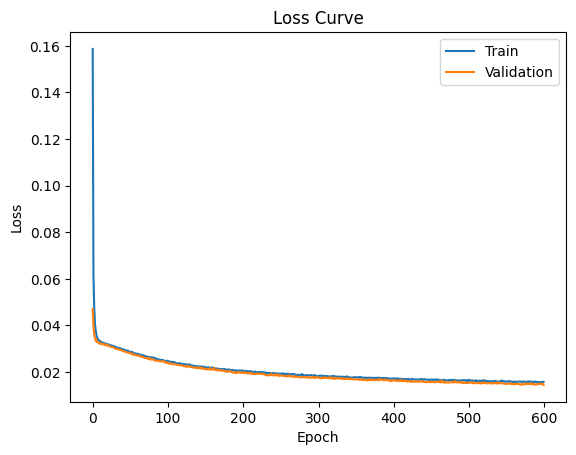

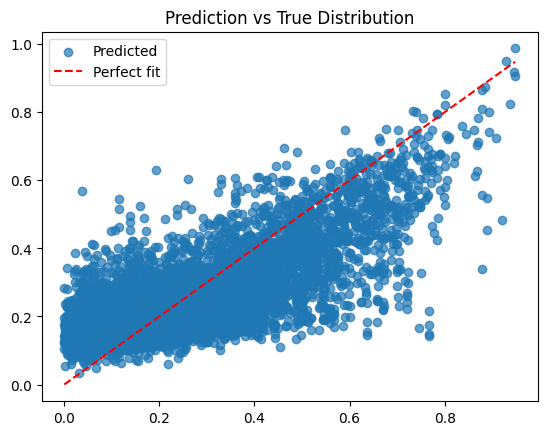

In [37]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [38]:
data= "Augmented Data"
encoding_method= 'K-mers Encoding'
feature_engineering= "With Feature Engineering"
run_id = 2
model_type = "MLP"
hyperparameters = {
    "epochs": 600,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


### MLP with Attention

In [ ]:
seq_len = 20        
d_model = 16 

seq_input = Input(shape=(seq_len,4), name='seq_input')
x = Dense(d_model, use_bias=False)(seq_input)  # (Projection)
position_embed = Embedding(input_dim=seq_len, output_dim=d_model)

def add_positional_encoding(t):
    pe = position_embed(tf.range(seq_len))                       
    return t + tf.expand_dims(pe, 0)

x = Lambda(add_positional_encoding, name='add_pos')(x)   

attention_output = MultiHeadAttention(num_heads=2, key_dim=d_model // 2, dropout=0.1, name='self_attn')(x, x)      

x = Add(name='attn_res')([x, attention_output])
x = LayerNormalization(name='attn_ln')(x)
attention_output = Flatten(name='gap')(x)    

x1 = Dense(256, kernel_initializer='he_normal')(attention_output)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Dense(128, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Dense(64, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 600,
    batch_size= 32
)

Epoch 1/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.3189 - mae: 0.4112 - val_loss: 0.0488 - val_mae: 0.1684
Epoch 2/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0593 - mae: 0.1932 - val_loss: 0.0391 - val_mae: 0.1485
Epoch 3/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0442 - mae: 0.1661 - val_loss: 0.0348 - val_mae: 0.1416
Epoch 4/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0381 - mae: 0.1540 - val_loss: 0.0331 - val_mae: 0.1405
Epoch 5/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0361 - mae: 0.1509 - val_loss: 0.0317 - val_mae: 0.1369
Epoch 6/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0337 - mae: 0.1462 - val_loss: 0.0306 - val_mae: 0.1378
Epoch 7/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0328 - mae: 0.1440 - val_loss: 0.0303 - val_mae: 0.1348
Epoch 8/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0322 - mae: 0.1425 - val_loss: 0.0302 - val_mae: 0.1339
Epoch 9/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/

In [39]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [40]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.004
  RMSE     : 0.067
  MAE      : 0.049
  R2 Score : 0.865
  Spearman : 0.889


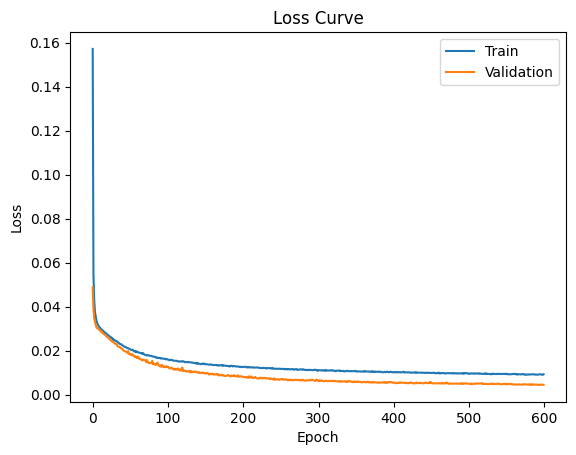

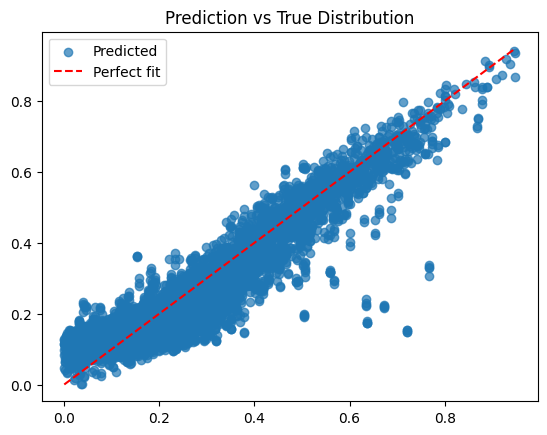

In [41]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [42]:
data= "Augmented Data"
encoding_method= '1 Hot Encoding + PE'
feature_engineering= "With Feature Engineering"
run_id = 3
model_type = "MLP + Attention"
hyperparameters = {
    "epochs": 600,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


# CNN

### Normal CNN

In [ ]:
#seq_len=20 #With one-hot encoding
#seq_input = Input(shape=(seq_len,4), name='seq_input') #With one-hot encoding
seq_len = 64  #With k-mers encoding
seq_input = Input(shape=(seq_len, 1), name="seq_input") #With k-mers encoding

x1 = Conv1D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(seq_input)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = GlobalMaxPooling1D()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 600,
    batch_size= 32
)

Epoch 1/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1282 - mae: 0.2602 - val_loss: 0.0352 - val_mae: 0.1443
Epoch 2/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0370 - mae: 0.1535 - val_loss: 0.0343 - val_mae: 0.1420
Epoch 3/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0342 - mae: 0.1483 - val_loss: 0.0332 - val_mae: 0.1505
Epoch 4/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0341 - mae: 0.1492 - val_loss: 0.0341 - val_mae: 0.1405
Epoch 5/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0331 - mae: 0.1468 - val_loss: 0.0323 - val_mae: 0.1443
Epoch 6/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0321 - mae: 0.1452 - val_loss: 0.0321 - val_mae: 0.1457
Epoch 7/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0321 - mae: 0.1444 - val_loss: 0.0322 - val_mae: 0.1407
Epoch 8/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0320 - mae: 0.1444 - val_loss: 0.0319 - val_mae: 0.1395
Epoch 9/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/

In [40]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [41]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.02
  RMSE     : 0.142
  MAE      : 0.107
  R2 Score : 0.39
  Spearman : 0.582


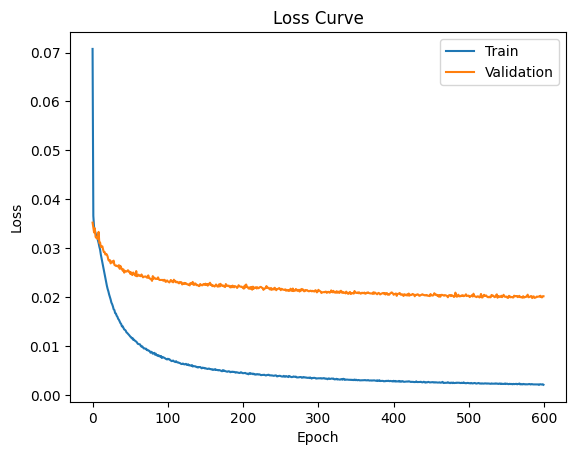

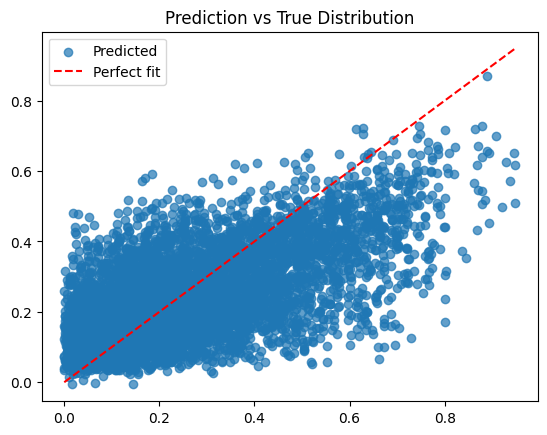

In [42]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [43]:
data= "Augmented Data"
encoding_method= 'K-mers Encoding'
feature_engineering= "With Feature Engineering"
run_id = 5
model_type = "CNN"
hyperparameters = {
    "epochs": 600,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


### CNN with Attention

In [ ]:
seq_len=20 
d_model = 16 

seq_input = Input(shape=(seq_len,4), name='seq_input') 
x = Dense(d_model, use_bias=False)(seq_input)  # (Projection)
position_embed = Embedding(input_dim=seq_len, output_dim=d_model)

def add_positional_encoding(t):
    pe = position_embed(tf.range(seq_len))                        
    return t + tf.expand_dims(pe, 0)

x = Lambda(add_positional_encoding, name='add_pos')(x)   

attention_output = MultiHeadAttention(num_heads=2, key_dim=d_model // 2, dropout=0.1, name='self_attn')(x, x)    

x = Add(name='attn_res')([x, attention_output])
x = LayerNormalization(name='attn_ln')(x)     

x1 = Conv1D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = GlobalMaxPooling1D()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 600,
    batch_size= 32
)

Epoch 1/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.4895 - mae: 0.5097 - val_loss: 0.0576 - val_mae: 0.1885
Epoch 2/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0637 - mae: 0.1988 - val_loss: 0.0416 - val_mae: 0.1572
Epoch 3/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0436 - mae: 0.1649 - val_loss: 0.0354 - val_mae: 0.1459
Epoch 4/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - loss: 0.0371 - mae: 0.1522 - val_loss: 0.0325 - val_mae: 0.1418
Epoch 5/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - loss: 0.0338 - mae: 0.1468 - val_loss: 0.0315 - val_mae: 0.1383
Epoch 6/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0320 - mae: 0.1431 - val_loss: 0.0303 - val_mae: 0.1369
Epoch 7/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0300 - mae: 0.1384 - val_loss: 0.0288 - val_mae: 0.1336
Epoch 8/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0275 - mae: 0.1322 - val_loss: 0.0278 - val_mae: 0.1292
Epoch 9/600
811/811 ━━━━━━━━━━━━━━━━━━━━ 5s

In [36]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [37]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.002
  RMSE     : 0.046
  MAE      : 0.026
  R2 Score : 0.936
  Spearman : 0.972


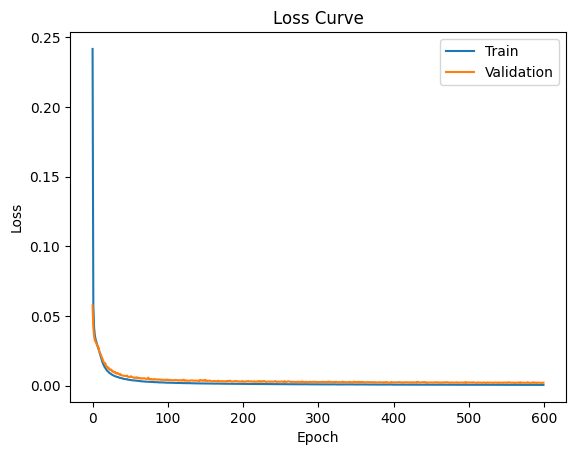

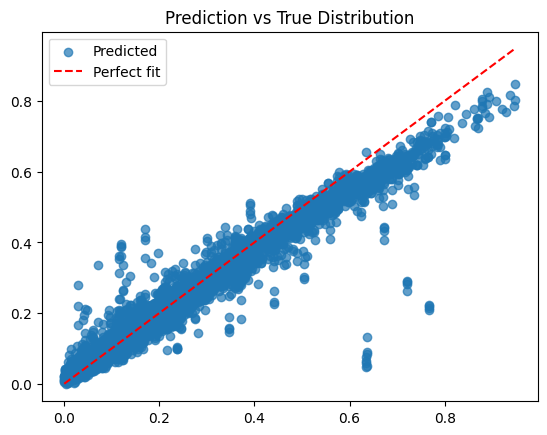

In [38]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [39]:
data= "Augmented Data"
encoding_method= '1 Hot Encoding + PE'
feature_engineering= "With Feature Engineering"
run_id = 6
model_type = "CNN + Attention"
hyperparameters = {
    "epochs": 600,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


# BiLSTM

### Normal BiLSTM

In [ ]:
#seq_len=20 #With one-hot encoding
#seq_input = Input(shape=(seq_len,4), name='seq_input') #With one-hot encoding
seq_len = 64  #With k-mers encoding
seq_input = Input(shape=(seq_len,1), name="seq_input") #With k-mers encoding

x1 = Bidirectional(LSTM(64, return_sequences=True))(seq_input)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Bidirectional(LSTM(128, return_sequences=True))(x1)
x1 = GlobalMaxPooling1D()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 350,
    batch_size= 32
)

Epoch 1/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - loss: 0.3281 - mae: 0.4147 - val_loss: 0.0486 - val_mae: 0.1726
Epoch 2/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 0.0629 - mae: 0.1970 - val_loss: 0.0390 - val_mae: 0.1555
Epoch 3/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 0.0477 - mae: 0.1726 - val_loss: 0.0388 - val_mae: 0.1488
Epoch 4/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 0.0413 - mae: 0.1612 - val_loss: 0.0357 - val_mae: 0.1481
Epoch 5/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.0382 - mae: 0.1557 - val_loss: 0.0347 - val_mae: 0.1471
Epoch 6/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.0372 - mae: 0.1542 - val_loss: 0.0351 - val_mae: 0.1442
Epoch 7/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 0.0356 - mae: 0.1514 - val_loss: 0.0346 - val_mae: 0.1436
Epoch 8/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.0347 - mae: 0.1494 - val_loss: 0.0335 - val_mae: 0.1445
Epoch 9/350
811/811 ━━━━━━━━━━━━

In [42]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


In [43]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.029
  RMSE     : 0.171
  MAE      : 0.129
  R2 Score : 0.115
  Spearman : 0.394


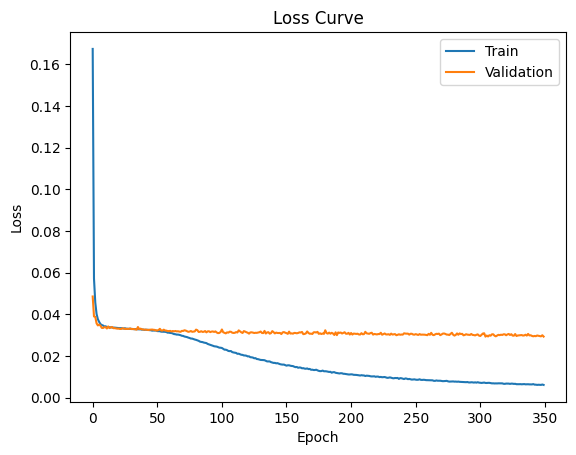

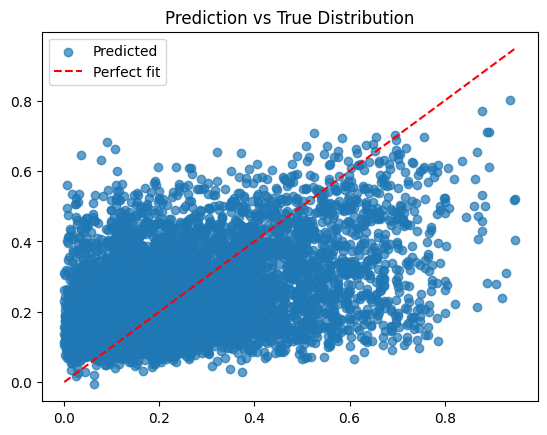

In [44]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [45]:
data= "Augmented Data"
encoding_method= 'K-mers Encoding'
feature_engineering= "With Feature Engineering"
run_id = 8
model_type = "BiLSTM"
hyperparameters = {
    "epochs": 350,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


### BiLSTM with Attention

In [ ]:
seq_len=20 
d_model = 16 

seq_input = Input(shape=(seq_len,4), name='seq_input') 

x = Dense(d_model, use_bias=False)(seq_input)  # (Projection)
position_embed = Embedding(input_dim=seq_len, output_dim=d_model)

def add_positional_encoding(t):
    pe = position_embed(tf.range(seq_len))                       
    return t + tf.expand_dims(pe, 0)

x = Lambda(add_positional_encoding, name='add_pos')(x)   

attention_output = MultiHeadAttention(num_heads=2, key_dim=d_model // 2, dropout=0.1, name='self_attn')(x, x)      

x = Add(name='attn_res')([x, attention_output])
x = LayerNormalization(name='attn_ln')(x)     

x1 = Bidirectional(LSTM(64, return_sequences=True))(x)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Bidirectional(LSTM(128, return_sequences=True))(x1)
x1 = GlobalMaxPooling1D()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 350,
    batch_size= 32
)

Epoch 1/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.2903 - mae: 0.3854 - val_loss: 0.0410 - val_mae: 0.1575
Epoch 2/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0510 - mae: 0.1778 - val_loss: 0.0359 - val_mae: 0.1455
Epoch 3/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0401 - mae: 0.1583 - val_loss: 0.0357 - val_mae: 0.1415
Epoch 4/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0369 - mae: 0.1517 - val_loss: 0.0327 - val_mae: 0.1397
Epoch 5/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.0346 - mae: 0.1487 - val_loss: 0.0326 - val_mae: 0.1394
Epoch 6/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0333 - mae: 0.1446 - val_loss: 0.0320 - val_mae: 0.1372
Epoch 7/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0327 - mae: 0.1441 - val_loss: 0.0312 - val_mae: 0.1356
Epoch 8/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0324 - mae: 0.1429 - val_loss: 0.0302 - val_mae: 0.1364
Epoch 9/350
811/811 ━━━━━━━━━━━━

In [36]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [37]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.001
  RMSE     : 0.035
  MAE      : 0.019
  R2 Score : 0.964
  Spearman : 0.982


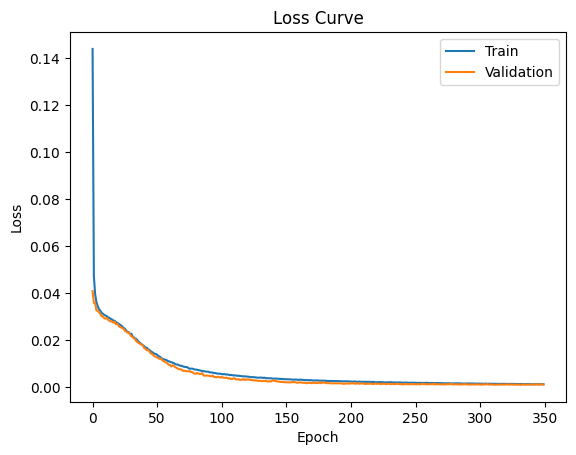

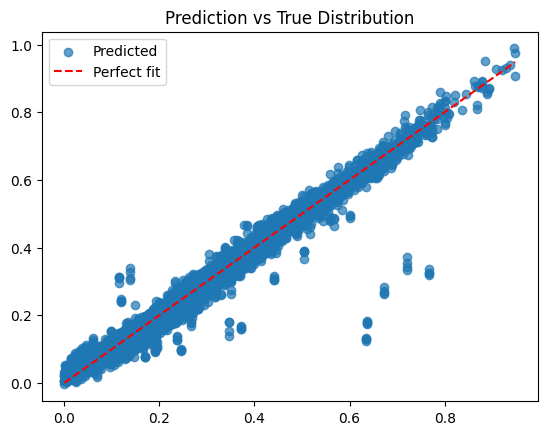

In [38]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [40]:
data= "Augmented Data"
encoding_method= '1 Hot Encoding + PE'
feature_engineering= "With Feature Engineering"
run_id = 9
model_type = "BiLSTM + Attention"
hyperparameters = {
    "epochs": 350,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done
